In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
import scikitplot as skplt
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, confusion_matrix
scaler = StandardScaler()

# Predicting Income With Classification

To recap: In the previous notebook (PART 1), I acquired, cleaned, feature engineered, and explored the data. I then discovered the best set of variables to use in predicting income of a listing. I modelled using regression, and found a RandomForestRegressor was the best bet in terms of accuracy scores (99% and 75%, with and without income-formulation-based predictors).

Something that became evident was how varied the data is, predicting exact income points was difficult. Now, I will try to do the same but with income classes using classification. Income will be split into 4 classes (A,B,C,D from highest to lowest).

# Importing The Main Dataframe

In [3]:
df = pd.read_csv("/Users/bridmcnulty/Desktop/cleaned_data.csv", low_memory=False)
df.drop(columns=['Unnamed: 0','host_id'],inplace=True)
df.head(1)

,id,experiences_offered,host_name,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,...,vader_compound,comment_length,vader_neu_summary,vader_compound_summary,vader_neg_summary,vader_pos_summary,vader_compound_desc,vader_pos_desc,vader_neg_desc,vader_neu_desc
0,13913,business,Alina,within a day,60.0,0,4.0,"['email', 'phone', 'facebook', 'reviews']",1,0,...,0.752046,88.464286,0.582,0.9747,0.028,0.39,0.9949,0.284,0.009,0.707


# Split Income Into Discrete Classes

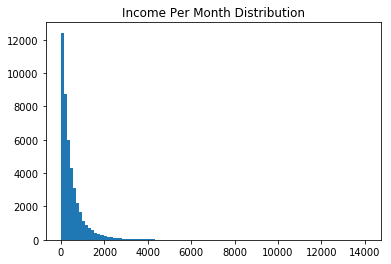

In [4]:
plt.hist(df.income,bins=100)
plt.title("Income Per Month Distribution")
plt.show()

In [5]:
# Looking at quartiles - I may split at these points:
df.income.describe()

count    44105.000000
mean       494.508495
std        631.560109
min          0.000000
25%        122.040000
50%        299.113640
75%        629.055600
max      14024.319400
Name: income, dtype: float64

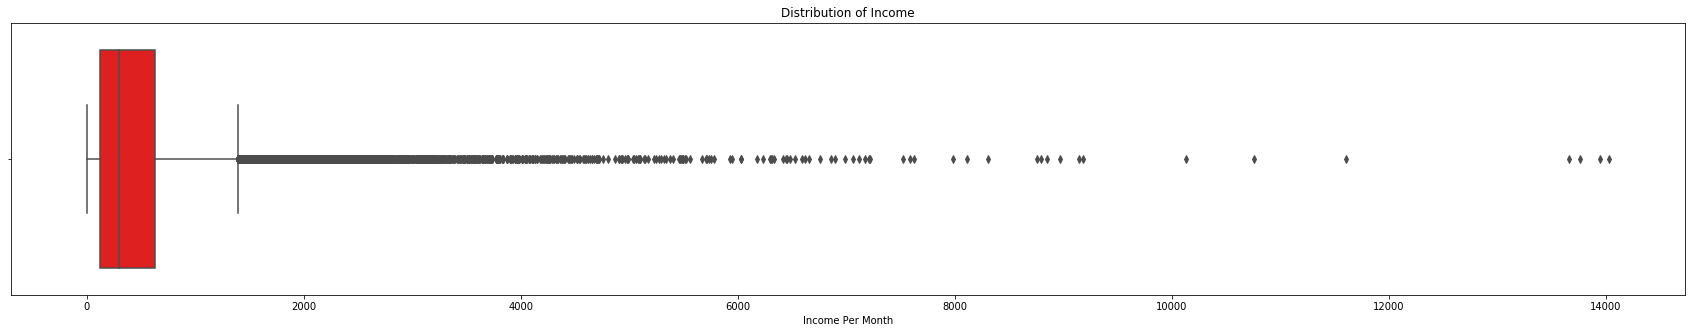

In [6]:
# Taking a look again at how income is distributed:
plt.figure(figsize=(30,5))
sns.boxplot(df.income,color='r')
plt.xlabel("Income Per Month")
plt.title("Distribution of Income")
plt.show()

I will try splitting by three methods:
- Firstly, by fairly balanced classes. Splitting at approximately the quartile boundaries
- Secondly, in a more subjective manner. Splitting at points that may indicate a host's intention behind a listing. E.g. The upper class 'A' includes income > £1000 per month. These people are likely renting full time, and aiming to make as much as they can. So a similar type of intention and behaviour. Whereas 'D' makes less than £100 a month, they likely rent the odd night here and there and don't put much effort into it.
- Thirdly, log transforming the income variable first, to transform the skewed distribution. Then split this in a balanced way.

In [7]:
# Firstly, Balanced boundaries:

def discrete_income(x):
    if x > 500:
        return 'A'
    elif x > 210:
        return 'B'
    elif x > 85:
        return 'C'
    else:
        return 'D'

In [8]:
# Subjective imbalanced boundaries:

def discrete_income2(x):
    if x > 1000:
        return 'A'
    elif x > 500:
        return 'B'
    elif x > 100:
        return 'C'
    else:
        return 'D'

In [9]:
# Working first with imbalanced classes, create the income class column:

df['income_class'] = df.income.map(discrete_income2)

In [10]:
# Taking a look at it's distribution:
df.income_class.value_counts()

C    20644
D     9101
B     8857
A     5503
Name: income_class, dtype: int64

**Log Transform Income**

In [11]:
# Add $1 to those with zero income so can do the log transform without getting infinity values:
df['income_log'] = df.income +1
df['income_log'] = df.income_log.apply(np.log)

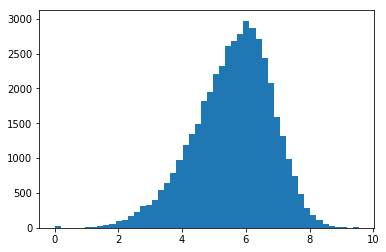

In [12]:
# After transforming - much better!
plt.hist(df.income_log,bins=50)
plt.show()

In [13]:
# Looking at the quartile boundaries for log transformed income:
df.income_log.describe()

count    44105.000000
mean         5.578652
std          1.223760
min          0.000000
25%          4.812510
50%          5.704161
75%          6.445808
max          9.548620
Name: income_log, dtype: float64

In [14]:
# Balanced boundaries for log income:

def discrete_income_log(x):
    if x > 6.12:
        return 'A'
    elif x > 5.37:
        return 'B'
    elif x > 4.46:
        return 'C'
    else:
        return 'D'

# Adding this new column:
df['income_class_log'] = df.income_log.map(discrete_income_log)

**Ready to move on now. I've set up a fitter function below to quickly fit models and output scores and reports**

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
def fitter(model, X_train, y_train, X_test, y_test):
    """
    Takes a model, training and test sets as inputs and evaluated the model on both 
    reporting scores, confusion matrix and classification report.
    """
    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)
    print("Train Score: ",model.score(X_train, y_train))
    print("Cross-Val Score: ",cross_val_score(model, X_train, y_train, cv=5).mean())
    print("Test Score: ",model.score(X_test, y_test))
    # classification report
    print("\n Classification Report \n")
    print(classification_report(y_test, predictions_test, target_names=['A','B','C','D']))
    # confusion Matrix
    skplt.metrics.plot_confusion_matrix(y_test, predictions_test)
    plt.show()

# Baseline For Imbalanced & Balanced Target Variable

We want our model scores to at least exceed these baseline scores. They're essentially the majority vote.


In [16]:
# For imbalanced classes:

df.income_class.value_counts(normalize=True)
# Baseline is 0.46

C    0.468065
D    0.206348
B    0.200816
A    0.124770
Name: income_class, dtype: float64

# FIX BALANCED CLASSES!!!!

In [40]:
# For balanced classes:
df1.income_class.value_counts(normalize=True)

# Baseline is 0.28

A    0.325587
B    0.284843
C    0.212720
D    0.176851
Name: income_class, dtype: float64

# PART 1: Choose Best Target Variable (Balanced/Imbalanced - Log/No-Log)

Classification on:

- Imbalanced Income_class (without log transformation)

- Imbalanced Income_class with rebalancing (SMOTE, RandomOverSampler) (without log)

- Balanced Income_class (without log)

- Balanced Income_class WITH log transform

All throughout, I'll be controlling for predictors, using the best ones from regression

# 1. Classification with The Imbalanced Classes (without log)

Train Score:  0.6426975026722379
Cross-Val Score:  0.6399767040672233
Test Score:  0.6435912938331319

 Classification Report 

              precision    recall  f1-score   support

           A       0.66      0.49      0.56      1651
           B       0.49      0.08      0.13      2657
           C       0.60      0.90      0.72      6194
           D       0.82      0.71      0.76      2730

   micro avg       0.64      0.64      0.64     13232
   macro avg       0.64      0.54      0.54     13232
weighted avg       0.63      0.64      0.59     13232



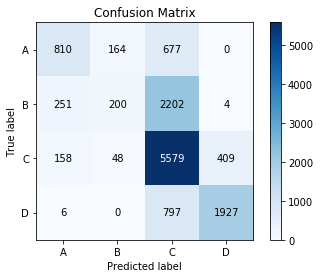

In [23]:
# Predictors are just the best ones from regression:

X = pd.get_dummies(df[['host_is_superhost',
        'neighbourhood_cleansed','tube_proximity','minimum_nights',
        'host_response_rate','host_since_ago',
        'host_listings_count','room_type','host_identity_verified',
        'longitude','accommodates','bathrooms','bedrooms','beds',
        'extra_people','availability_30','availability_60',
        'availability_90','availability_365','number_of_reviews','review_scores_accuracy',
        'review_scores_cleanliness','review_scores_rating',
        'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
        'first_review_days_ago','latitude','vader_neu','vader_pos','vader_neg','vader_compound','comment_length']],drop_first=True)
y = df.income_class

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=1)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

model = LogisticRegression(solver='liblinear', multi_class='ovr',C=10,penalty='l1')
fitter(model, X_train, y_train, X_test, y_test)

# 2. Classification with The Imbalanced Classes with Rebalancing (without log)

In [24]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import RandomOverSampler

X = pd.get_dummies(df[['host_is_superhost',
        'neighbourhood_cleansed','tube_proximity','minimum_nights',
        'host_response_rate','host_since_ago',
        'host_listings_count','room_type','host_identity_verified',
        'longitude','accommodates','bathrooms','bedrooms','beds',
        'extra_people','availability_30','availability_60',
        'availability_90','availability_365','number_of_reviews','review_scores_accuracy',
        'review_scores_cleanliness','review_scores_rating',
        'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
        'first_review_days_ago','latitude',
        'vader_neu','vader_pos','vader_neg','vader_compound','comment_length']],drop_first=True)
y = df.income_class

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=1)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

Train Score:  0.5803128947624138
Cross-Val Score:  0.5741592029864127
Test Score:  0.5841898428053204

 Classification Report 

              precision    recall  f1-score   support

           A       0.44      0.81      0.57      1651
           B       0.43      0.42      0.42      2657
           C       0.78      0.45      0.57      6194
           D       0.62      0.91      0.74      2730

   micro avg       0.58      0.58      0.58     13232
   macro avg       0.57      0.65      0.58     13232
weighted avg       0.64      0.58      0.58     13232



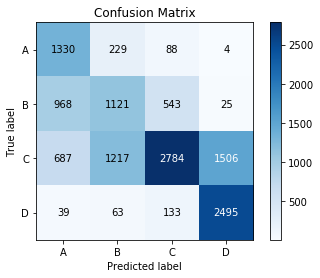

In [25]:
# Using RandomOverSampler:
pipe = make_pipeline_imb(RandomOverSampler(random_state=1),
                         LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000))

fitter(pipe, X_train, y_train, X_test, y_test)

In [26]:
# Next try rebalancing with SMOTE:
from imblearn.over_sampling import SMOTE

Train Score:  0.5840702231723512
Cross-Val Score:  0.5770738418687933
Test Score:  0.588422007255139

 Classification Report 

              precision    recall  f1-score   support

           A       0.44      0.80      0.57      1651
           B       0.42      0.44      0.43      2657
           C       0.79      0.46      0.58      6194
           D       0.63      0.91      0.75      2730

   micro avg       0.59      0.59      0.59     13232
   macro avg       0.57      0.65      0.58     13232
weighted avg       0.64      0.59      0.58     13232



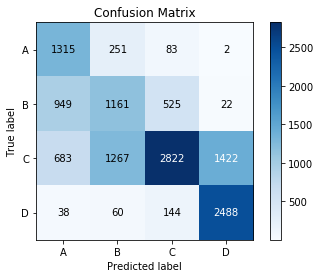

In [27]:
pipe = make_pipeline_imb(SMOTE(random_state=1),
                         LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000))

fitter(pipe, X_train, y_train, X_test, y_test)

# 3. Classification with Balanced Classes (without log)

In [29]:
# Temporary dataframe with balanced income classes this time:
df1 = df.copy(deep=True)
df1['income_class'] = df.income.map(discrete_income)
df1.dropna(inplace=True)
df1.head(2)

,id,experiences_offered,host_name,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,...,vader_compound_summary,vader_neg_summary,vader_pos_summary,vader_compound_desc,vader_pos_desc,vader_neg_desc,vader_neu_desc,income_class,income_log,income_class_log
0,13913,business,Alina,within a day,60.0,0,4.0,"['email', 'phone', 'facebook', 'reviews']",1,0,...,0.9747,0.028,0.39,0.9949,0.284,0.009,0.707,D,3.367275,D
1,15400,romantic,Philippa,within a few hours,100.0,0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,1,...,-0.4404,0.062,0.00,0.9586,0.120,0.016,0.864,B,5.628858,B


Train Score:  0.6288666472322094
Cross-Val Score:  0.6238459558323889
Test Score:  0.623186215235792

 Classification Report 

              precision    recall  f1-score   support

           A       0.67      0.87      0.75      4308
           B       0.53      0.48      0.50      3769
           C       0.55      0.27      0.36      2815
           D       0.69      0.82      0.75      2340

   micro avg       0.62      0.62      0.62     13232
   macro avg       0.61      0.61      0.59     13232
weighted avg       0.61      0.62      0.60     13232



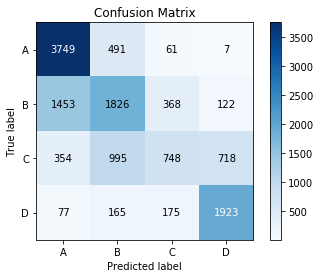

In [30]:
X = pd.get_dummies(df1[['host_is_superhost',
        'neighbourhood_cleansed','tube_proximity','minimum_nights',
        'host_response_rate','host_since_ago',
        'host_listings_count','room_type','host_identity_verified',
        'longitude','accommodates','bathrooms','bedrooms','beds',
        'extra_people','availability_30','availability_60',
        'availability_90','availability_365','number_of_reviews','review_scores_accuracy',
        'review_scores_cleanliness','review_scores_rating',
        'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
        'first_review_days_ago','latitude',
        'vader_neu','vader_pos','vader_neg','vader_compound','comment_length']],drop_first=True)
y = df1.income_class

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=1,shuffle=True)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=100)
fitter(model, X_train, y_train, X_test, y_test)

# 4. Classification with Balanced Classes WITH Log Transform on Income

Train Score:  0.6278301428432611
Cross-Val Score:  0.6196999115442088
Test Score:  0.6251511487303507

 Classification Report 

              precision    recall  f1-score   support

           A       0.66      0.92      0.77      4745
           B       0.50      0.29      0.37      3255
           C       0.52      0.35      0.42      2883
           D       0.69      0.83      0.76      2349

   micro avg       0.63      0.63      0.63     13232
   macro avg       0.59      0.60      0.58     13232
weighted avg       0.60      0.63      0.59     13232



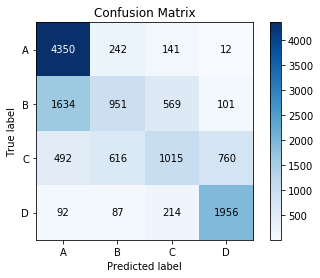

In [31]:
# Predictors are just the best ones from regression:

X = pd.get_dummies(df[['host_is_superhost',
        'neighbourhood_cleansed','tube_proximity','minimum_nights',
        'host_response_rate','host_since_ago',
        'host_listings_count','room_type','host_identity_verified',
        'longitude','accommodates','bathrooms','bedrooms','beds',
        'extra_people','availability_30','availability_60',
        'availability_90','availability_365','number_of_reviews','review_scores_accuracy',
        'review_scores_cleanliness','review_scores_rating',
        'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
        'first_review_days_ago','latitude','vader_neu','vader_pos','vader_neg','vader_compound','comment_length']],drop_first=True)
y = df.income_class_log

scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=1)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

model = LogisticRegression(solver='liblinear', multi_class='ovr',C=10,penalty='l1')
fitter(model, X_train, y_train, X_test, y_test)

# PART 2: A Quick Glance Of Modelling

Imbalanced classes (without log transform or rebalancing) performed best when controlling for predictor choices.

Now I will take a quick look at a simple LogisticRegression using these predictors, and the imbalanced income target.

In [34]:
# Setting up X,y to be used for remainder of modelling:

main_feats=df[[
               'host_is_superhost','security_deposit','host_response_rate','host_response_time','host_since_ago',
               'host_listings_count','room_type','host_has_profile_pic','host_identity_verified',
               'accommodates','bathrooms','bedrooms','guests_included','extra_people','availability_30','instant_bookable',
               'cancellation_policy','require_guest_profile_picture','first_review_days_ago','last_review_days_ago','bed_type',
               'vader_pos_desc','vader_compound_summary','tube_proximity','d_british_museum','d_churchill_war_room',
               'review_scores_rating','review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews',
               'vader_pos','vader_neg','comment_length','vader_compound','a_TV','a_kitchen','total_amenities','a_toilet_paper']]

X = pd.get_dummies(main_feats,drop_first=True)
y = df.income_class

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=1)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

Train Score:  0.6485602306222266
Cross-Val Score:  0.6458719970169009
Test Score:  0.6481257557436517

 Classification Report 

              precision    recall  f1-score   support

           A       0.69      0.47      0.56      1651
           B       0.51      0.09      0.16      2657
           C       0.61      0.91      0.73      6194
           D       0.83      0.69      0.75      2730

   micro avg       0.65      0.65      0.65     13232
   macro avg       0.66      0.54      0.55     13232
weighted avg       0.64      0.65      0.60     13232



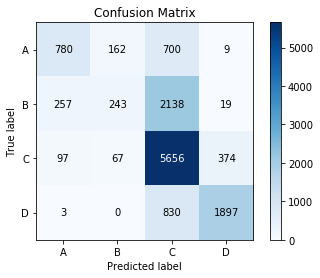

In [33]:
model = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=100,penalty='l1')
fitter(model, X_train, y_train, X_test, y_test)

# PART 3: Find The Best Model Type

Now we've found that using imbalanced income classes as a target is our best bet as a target.

We've got our predictors.

Now, we will find which model type leads to the best outcome.

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC

models = [KNeighborsClassifier(),
          LogisticRegression(solver='lbfgs', multi_class='ovr'),
          DecisionTreeClassifier(),
          SVC(gamma='scale'),
          RandomForestClassifier(n_estimators=100),
          ExtraTreesClassifier(n_estimators=100)]

res = []

for model in models:
    print(model)
    print()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    print(score)
    print() 
    res.append([model, score])
    print() 
    print('-'*60)
    print()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

0.5448911729141476


------------------------------------------------------------

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

0.6475211608222491


------------------------------------------------------------

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

0.6565145102781137


-----------------------------

SVC and RandomForestClassifier gave us the best accuracy scores.

# Part 4: Optimize The Best Models - SVC & RandomForestClassifer

To recap so far: 
- Found imbalanced income classes to be the best target (without log transform or balancing).
- Then looked at which set of features to use. The best was also the best set from regression - where I went one-by-one through all features choosing only those that boosted accuracy, while limiting total feature count.
- Then tested which model type performs best. This was SVC.
- Now we're optimising for SVC.
- And taking a look at the confusion matrices, classification reports and feature importances of models.

Train Score:  0.784180351763677
Cross-Val Score:  0.7187841367618948
Test Score:  0.7342805320435308

 Classification Report 

              precision    recall  f1-score   support

           A       0.78      0.55      0.64      1651
           B       0.61      0.54      0.57      2657
           C       0.73      0.88      0.80      6194
           D       0.84      0.71      0.77      2730

   micro avg       0.73      0.73      0.73     13232
   macro avg       0.74      0.67      0.70     13232
weighted avg       0.74      0.73      0.73     13232



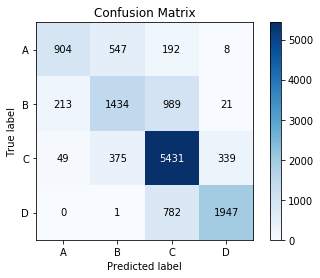

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [36]:
model = SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

fitter(model, X_train, y_train, X_test, y_test)

NOTE:
If we have two highly correlated features, our model could split on either to achieve the same effect. However, once it has split on one of the features, the power of the other is greatly reduced because the purity gain has been realized. 

So the second feature may show up with no importance.
This may cause problems with interpretation if one of the features has no causal effect, but is correlated with a feature that does have a causal effect.

# Look At Feature Importance For RandomForestClassifier

The RandomForest (RF) didn't give us the best accuracy score, but was second best. The reason for digging further with this is:

As seen, the decision tree placed heavy importance on a handful of features, ignoring others.
    
Random forests are a further way of averaging multiple deep decision trees, trained on different parts of the same training set, with the goal of reducing the variance. This comes at the expense of a small increase in the bias and some loss of interpretability, but generally greatly boosts the performance of the final model.
    
Random forests differ from bagging decision trees in only one way: they use a modified tree learning algorithm that selects, at each candidate split in the learning process, a random subset of the features. 
    
The reason for doing this is due to correlation of trees in an ordinary bootstrap sample: if one or a few features are very strong predictors for the response variable (target output), these features will be selected in many of the bagging base trees, causing them to become correlated. By selecting a random subset of the features at each split, we avoid this correlation between base trees, strengthening the overall model.

Train Score:  1.0
Cross-Val Score:  0.9163990449378911
Test Score:  0.9286577992744861

 Classification Report 

              precision    recall  f1-score   support

           A       0.97      0.89      0.93      1651
           B       0.88      0.86      0.87      2657
           C       0.92      0.97      0.94      6194
           D       0.97      0.93      0.95      2730

   micro avg       0.93      0.93      0.93     13232
   macro avg       0.94      0.91      0.92     13232
weighted avg       0.93      0.93      0.93     13232



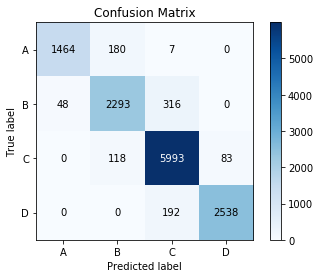

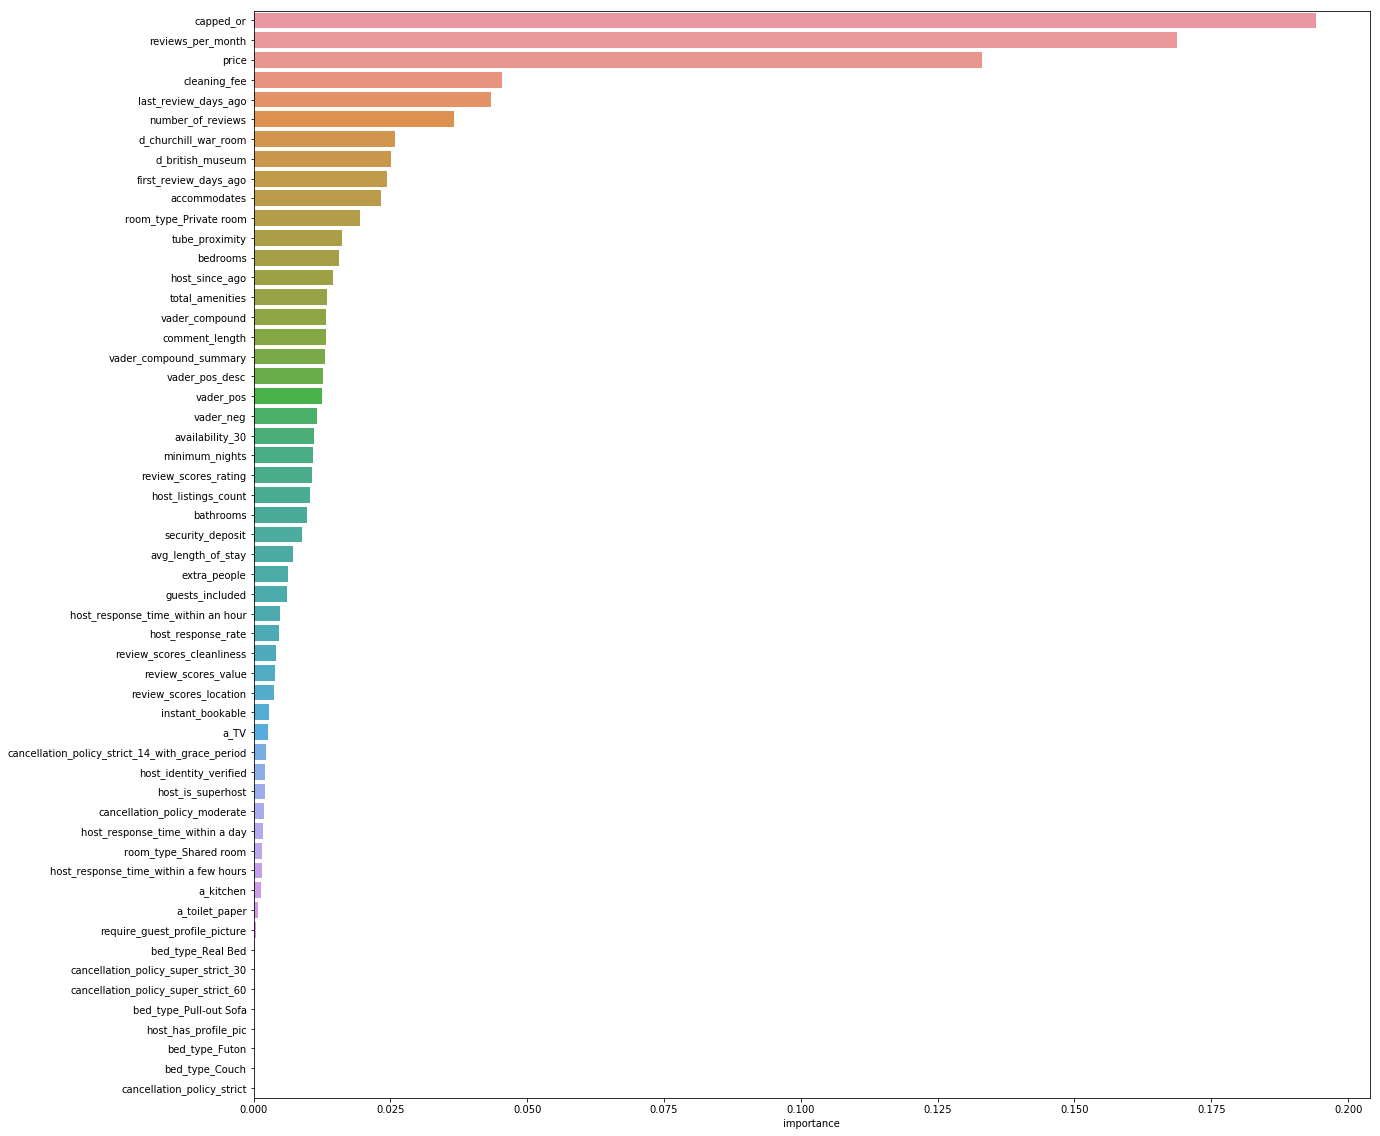

In [38]:
# First check out the feature importance with untuned parameters and the full predictor list (with forumla-based included):
X = pd.get_dummies(df[['reviews_per_month', 'price','cleaning_fee','minimum_nights','avg_length_of_stay','capped_or',
               'host_is_superhost','security_deposit','host_response_rate','host_response_time','host_since_ago',
               'host_listings_count','room_type','host_has_profile_pic','host_identity_verified',
               'accommodates','bathrooms','bedrooms','guests_included','extra_people','availability_30','instant_bookable',
               'cancellation_policy','require_guest_profile_picture','first_review_days_ago','last_review_days_ago','bed_type',
               'vader_pos_desc','vader_compound_summary','tube_proximity','d_british_museum','d_churchill_war_room',
               'review_scores_rating','review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews',
               'vader_pos','vader_neg','comment_length','vader_compound','a_TV','a_kitchen','total_amenities','a_toilet_paper'
            ]],drop_first=True)
y = df.income_class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=1)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

fitter(model, X_train, y_train, X_test, y_test)

feature_importances = pd.DataFrame(model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance'])
feature_importances['absolute_values'] = feature_importances.importance.abs()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20,20))
sns.barplot(feature_importances.importance,feature_importances.index)
plt.show()

# Already we can see the spread of features used in predicting is better than the DT (when including formula-based predictors)

Train Score:  1.0
Cross-Val Score:  0.7219898750191432
Test Score:  0.7280834340991535

 Classification Report 

              precision    recall  f1-score   support

           A       0.81      0.60      0.69      1651
           B       0.61      0.42      0.50      2657
           C       0.70      0.91      0.79      6194
           D       0.87      0.70      0.78      2730

   micro avg       0.73      0.73      0.73     13232
   macro avg       0.75      0.66      0.69     13232
weighted avg       0.73      0.73      0.72     13232



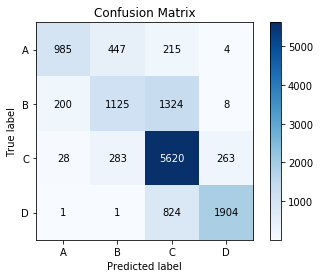

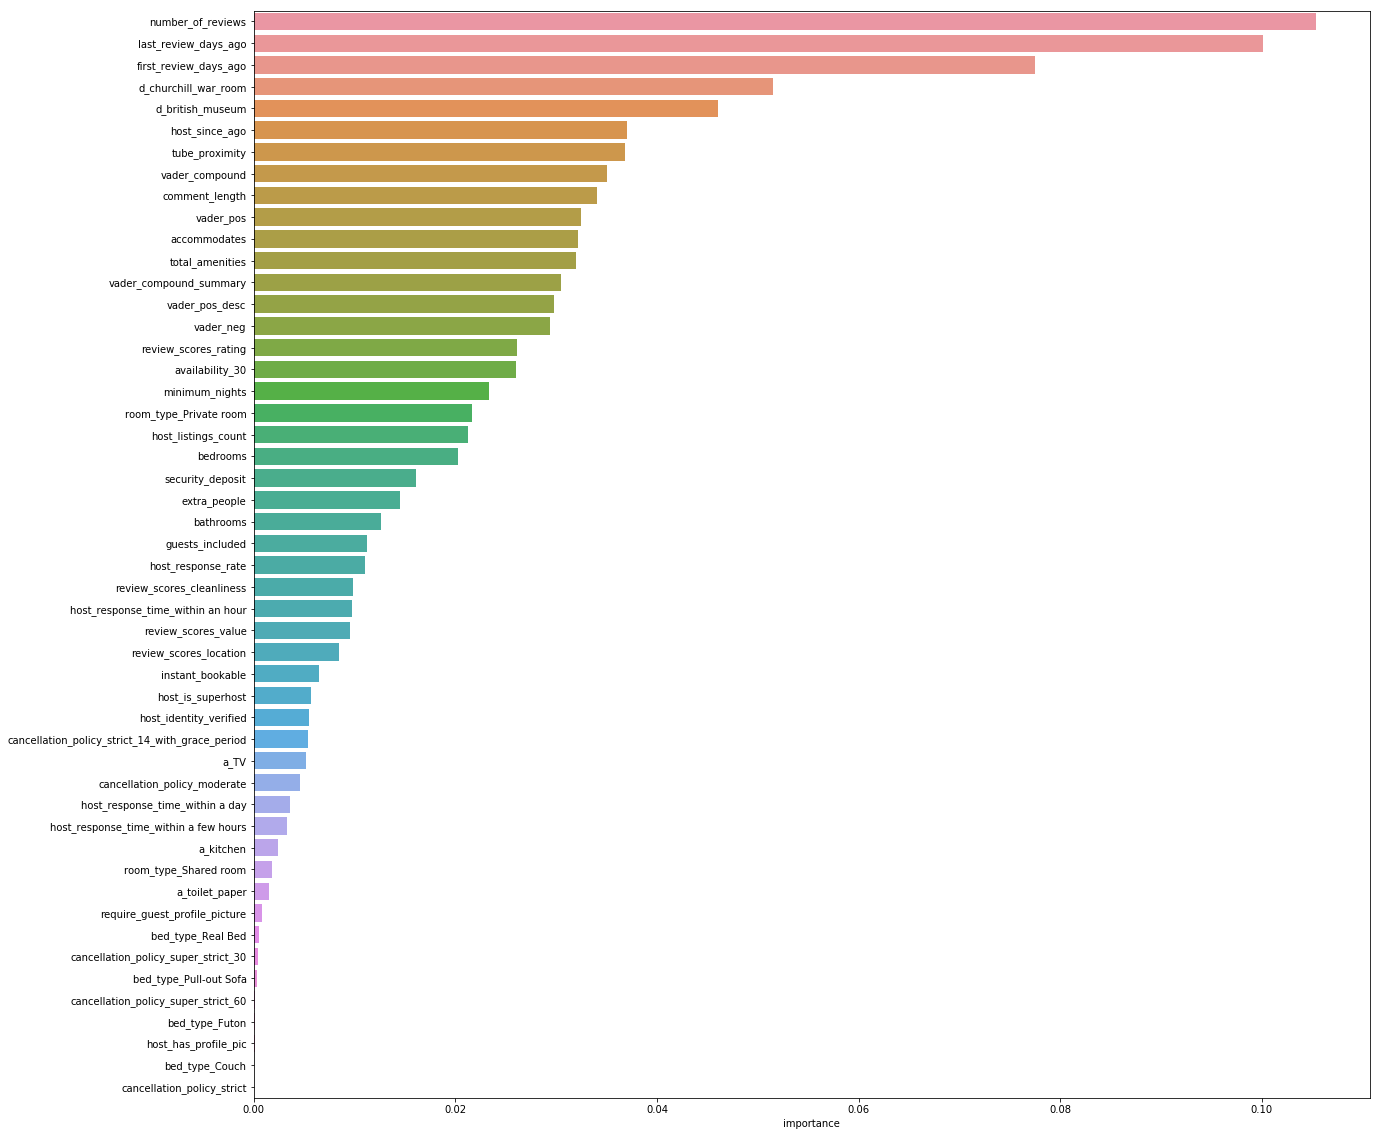

In [39]:
# Let's check RandomForest without formula-based predictors:
X = pd.get_dummies(df[['minimum_nights','host_is_superhost','security_deposit','host_response_rate','host_response_time','host_since_ago',
               'host_listings_count','room_type','host_has_profile_pic','host_identity_verified',
               'accommodates','bathrooms','bedrooms','guests_included','extra_people','availability_30','instant_bookable',
               'cancellation_policy','require_guest_profile_picture','first_review_days_ago','last_review_days_ago','bed_type',
               'vader_pos_desc','vader_compound_summary','tube_proximity','d_british_museum','d_churchill_war_room',
               'review_scores_rating','review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews',
               'vader_pos','vader_neg','comment_length','vader_compound','a_TV','a_kitchen','total_amenities','a_toilet_paper']],drop_first=True)
y = df.income_class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=1)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

fitter(model, X_train, y_train, X_test, y_test)

feature_importances = pd.DataFrame(model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance'])
feature_importances['absolute_values'] = feature_importances.importance.abs()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)


plt.figure(figsize=(20,20))
sns.barplot(feature_importances.importance,feature_importances.index)
plt.show()

**So far:**
- When looking at predictors without formula-based predictors, the RF performs best. It also improves the bias-variance tradeoff, and outputs good precision and recall scores.
- The DT performs better when including formula-based predictors.

# Feature Importance

Unlike in regression, where we could look at coefficients and their direct impact on income in pounds as they're increased, with RF and DT we have to look at feature importance.

Generally, importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. 

The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

The DT and RF output similar features of importance, namely: number_of_reviews, last_review_days_ago, first_review_days_ago, d_churchill_warroom, d_british_musuem, host_since_ago, accommodates, tube_proximity, vader_compound, comment_length and more. It's interesting to see how varied the variables are - there are vader scores, location-based, review-based and host-related variables.

The features even overlap quite a bit with the LinearRegression coefficients!

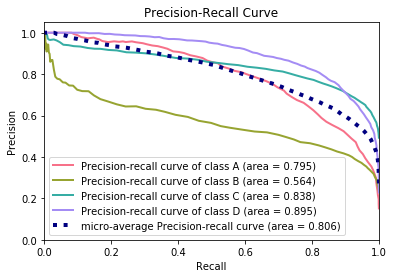

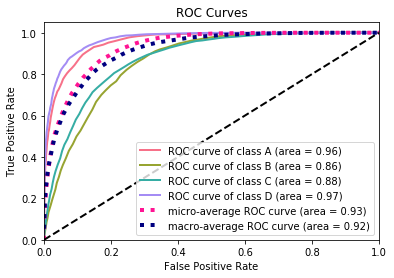

In [41]:
# Plot Precision-Recall Curve and ROC Curve for the RandomForestRegressor (without formula-based predictors)

from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", len(model.classes_)))
import scikitplot as skplt

probabilities_train = model.predict_proba(X_train)
probabilities_test = model.predict_proba(X_test)

skplt.metrics.plot_precision_recall(y_test, probabilities_test, cmap=cmap)
plt.show()

skplt.metrics.plot_roc(y_test, probabilities_test, cmap=cmap)
plt.show()

# We can see the scores are pretty respectable. 
    # Class B has the lowest precision-recall scores
    # While class D does very well on both charts 
        # this may be because the lowest income listings are all fairly similar i.e. hosts aren't engaged, aren't trying to promote the listing, and likely have low metrics across the board.


NOTE: I tried to tune the RF with a GridSearchCV but my computer didn't have enough computing power! The code is at the bottom of this notebook, if ever I can run it!

# Conclusion Overall

From a classification standpoint, the best outcome came from a RandomForestRegressor with an accuracy score of 0.92. When removing formula-based variables, the score dropped to 75.6. The target was imbalanced income classes without any transformation or rebalancing. The predictors were found using LinearRegression, adding/removing predictors one-by-one checking which improves accuracy.

The confusion matrices for both of these models were impressive. And true positive and false positive rates were low - which was a key metric as we wanted to avoid, for example, telling hosts they'll make a certain income but in reality make less.

The RandomForestClassifier matched the RandomForestRegressor from PART 1 (75.9% vs. 75.6%). 

Though, the classifier allows us to look at a confusion matrix and tr

Takeaways from LinearRegression (68.5%):
- Every additional review_per_month leads to £250 more per month
- Every additional minimum_night reduces income by £120
- Every additional person a listing can accommodate increases income by £30 per month.
- 

# Vader Scores Exploration

As mentioned in PART 1, I've done some exploration of the vader scores below, now that I can segment by income class.

In [107]:
# Subsetting by income class on written vader scores:

test = df1[['income_class','vader_pos','vader_neg','vader_neu','vader_compound']]
subset_A = test[test['income_class']=='A']
subset_B = test[test['income_class']=='B']
subset_C = test[test['income_class']=='C']
subset_D = test[test['income_class']=='D']

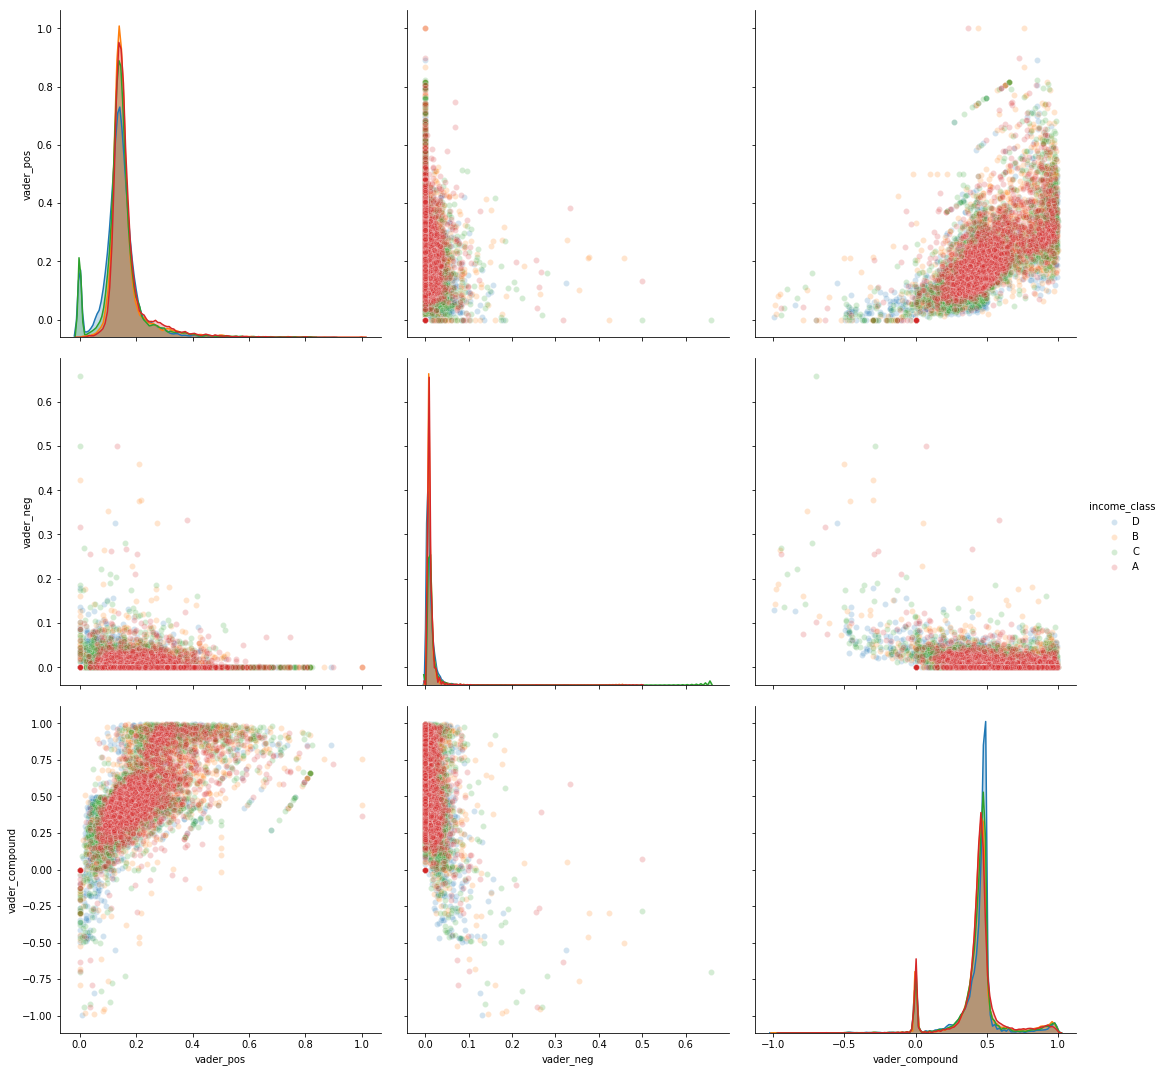

In [109]:
# A quick look at vader scores by income class:

sns.pairplot(test, vars=['vader_pos', 'vader_neg', 'vader_compound'], hue='income_class', 
             plot_kws={'alpha': 0.2}, height=5)
plt.show()

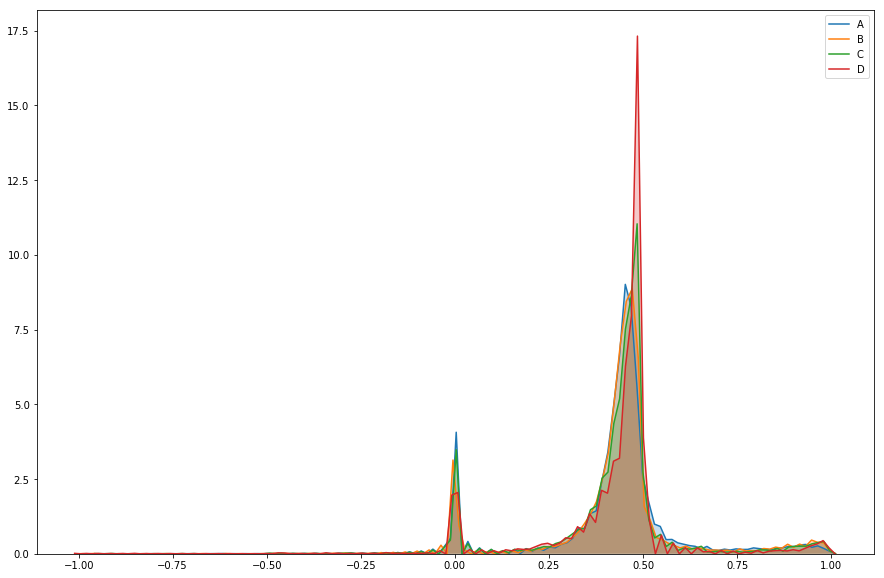

In [108]:
# A closer look at vader compound splits:

plt.figure(figsize=(15,10))
sns.kdeplot(subset_A.vader_compound, bw=0.005, label="A",shade=True)
sns.kdeplot(subset_B.vader_compound, bw=0.005, label="B",shade=True)
sns.kdeplot(subset_C.vader_compound, bw=0.005, label="C",shade=True)
sns.kdeplot(subset_D.vader_compound, bw=0.005, label="D",shade=True)
plt.legend()
plt.show()

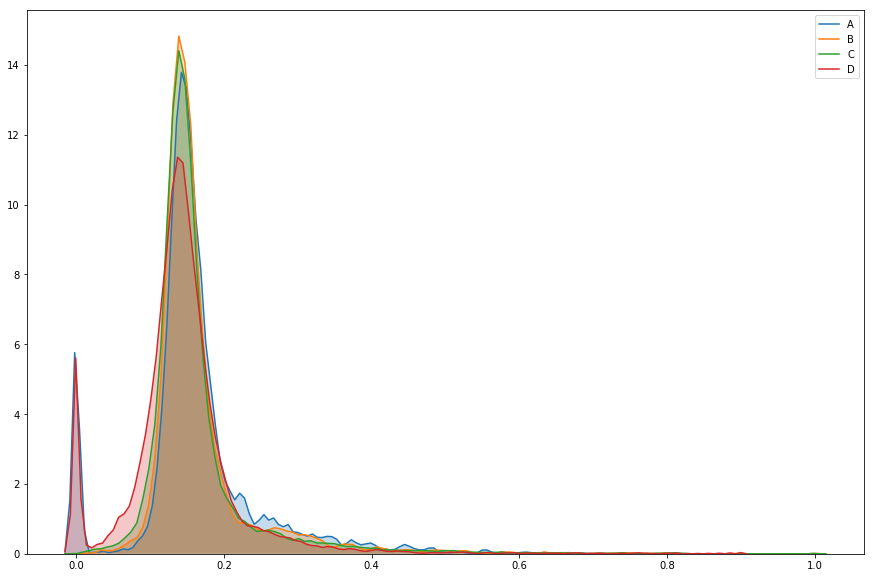

In [67]:
# A closer look at vader positive splits:
    
plt.figure(figsize=(15,10))
sns.kdeplot(subset_A.vader_pos, bw=0.005, label="A",shade=True)
sns.kdeplot(subset_B.vader_pos, bw=0.005, label="B",shade=True)
sns.kdeplot(subset_C.vader_pos, bw=0.005, label="C",shade=True)
sns.kdeplot(subset_D.vader_pos, bw=0.005, label="D",shade=True)
plt.legend()
plt.show()

It seems that most classes overlap in terms of vader scores. But there are subtle differences. Just above, with written review vader_pos score you can see 'A' class has more positive scores, and 'D' has more low.

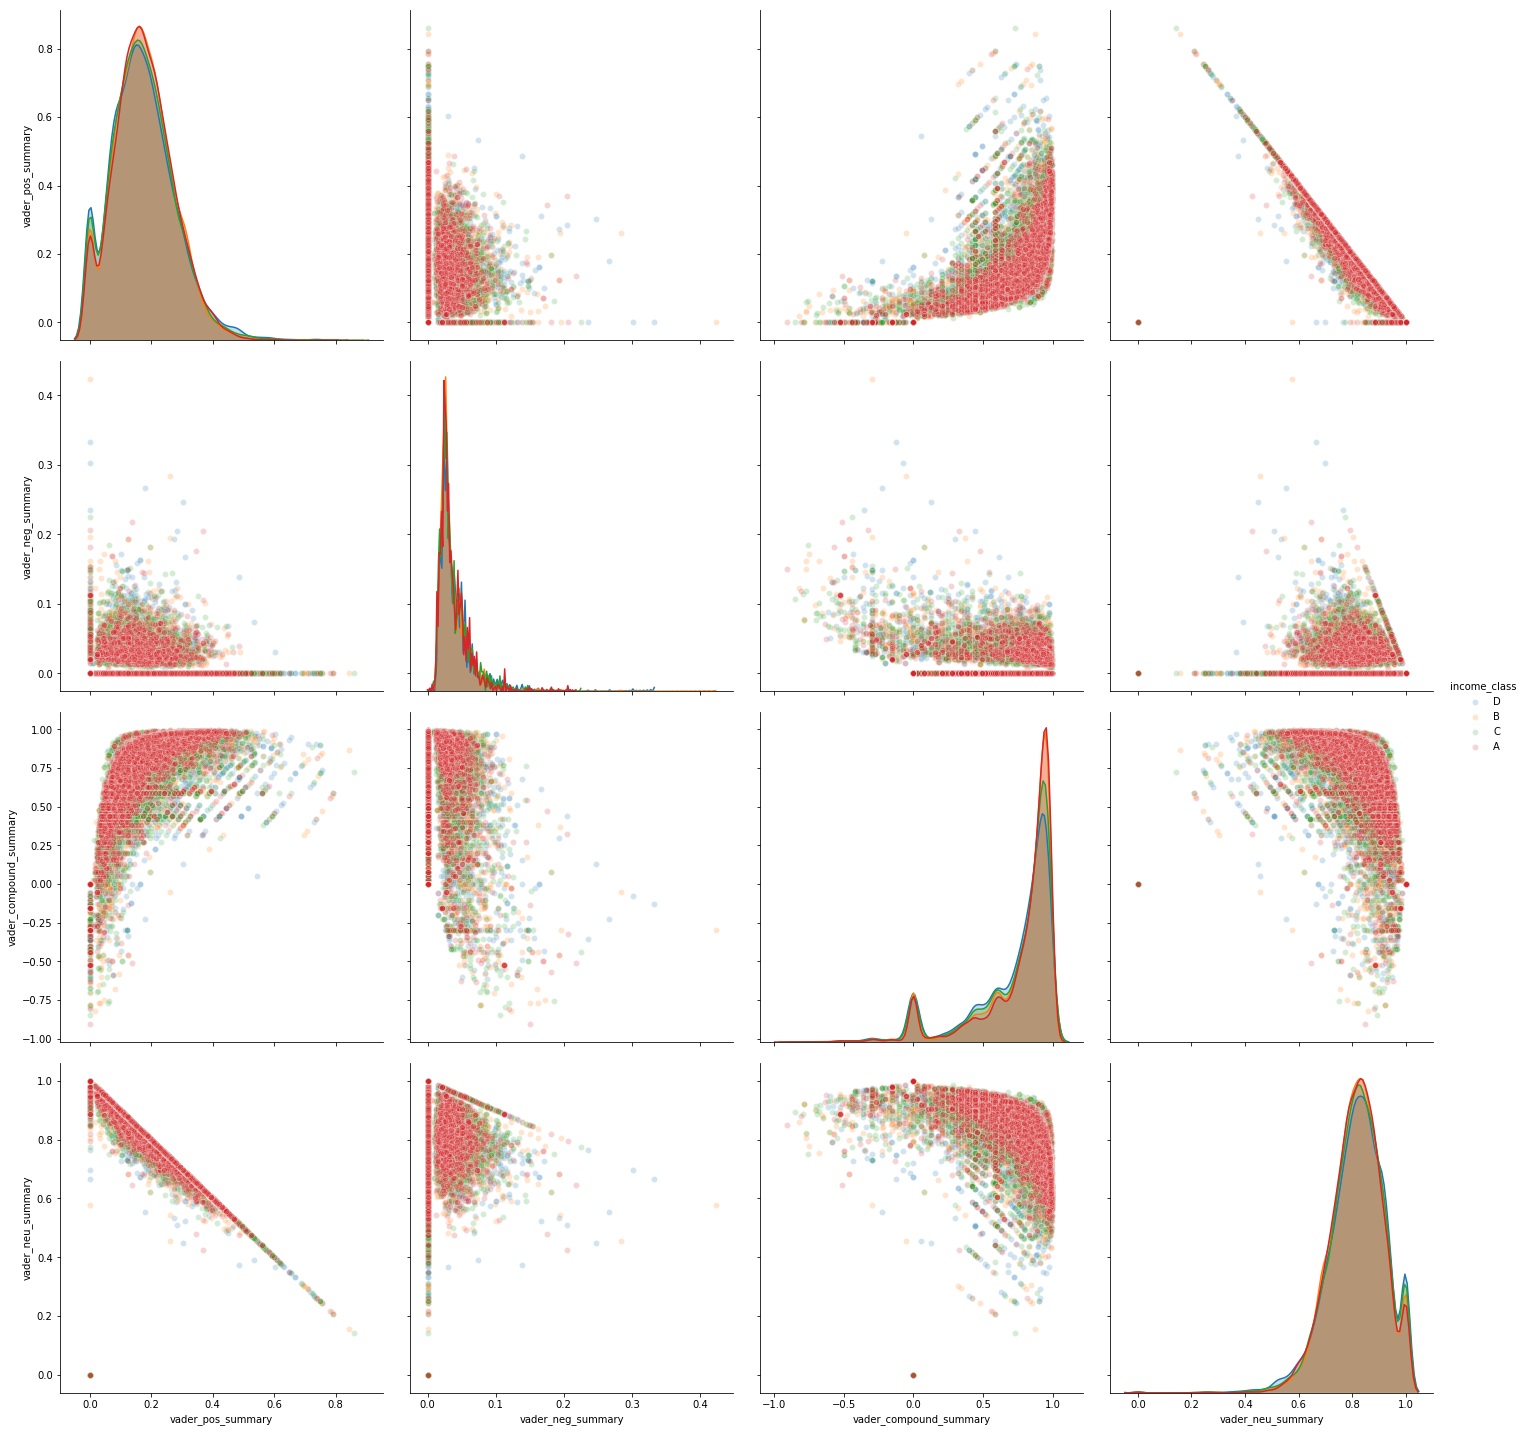

In [112]:
# Subsetting by income class

summary = df1[['income_class','vader_pos_summary','vader_neg_summary','vader_neu_summary','vader_compound_summary']]
subset_A = test[test['income_class']=='A']
subset_B = test[test['income_class']=='B']
subset_C = test[test['income_class']=='C']
subset_D = test[test['income_class']=='D']

sns.pairplot(test, vars=['vader_pos_summary', 'vader_neg_summary', 'vader_compound_summary','vader_neu_summary'], hue='income_class', 
             plot_kws={'alpha': 0.2}, height=5)
plt.show()

Again, a lot of overlap. It's surprising how several vader scores showed up in the final RandomForestClassifier!

# Save Income_Classes and Id to Be Imported Elsewhere

In [19]:
export = df[['id','income_class']]

In [20]:
export.to_csv("/Users/bridmcnulty/Desktop/id_and_income_class_imbalanced.csv")

In [102]:
# If ever have computing power for the RF GridSearch:

 # RandomForest GridSearchCV to find optimal parameters:

# X = pd.get_dummies(df[['reviews_per_month', 'price','cleaning_fee','minimum_nights','avg_length_of_stay','capped_or',
#                'host_is_superhost','security_deposit','host_response_rate','host_response_time','host_since_ago',
#                'host_listings_count','room_type','host_has_profile_pic','host_identity_verified',
#                'accommodates','bathrooms','bedrooms','guests_included','extra_people','availability_30','instant_bookable',
#                'cancellation_policy','require_guest_profile_picture','first_review_days_ago','last_review_days_ago','bed_type',
#                'vader_pos_desc','vader_compound_summary','tube_proximity','d_british_museum','d_churchill_war_room',
#                'review_scores_rating','review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews',
#                'vader_pos','vader_neg','comment_length','vader_compound','a_TV','a_kitchen','total_amenities','a_toilet_paper']],drop_first=True)
# y = df.income_class

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=1)

# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# X_train = pd.DataFrame(X_train, columns=X.columns)
# X_test = pd.DataFrame(X_test, columns=X.columns)

# model = RandomForestClassifier(criterion='gini',random_state=1)


# params = {'n_estimators' : [50,100,150], # 'n_estimators' is the number of decision trees created to evaluate individually
#           'max_depth': [10,20]+[None], #how many nodes deep can the decision tree go?
#           'max_features' : [20,40,55]+[None], # number of features to consider when looking for the best split
#           'max_leaf_nodes' : [3,50,100]+[None],# how many leaves can be generated per node
#           'min_samples_leaf' : [1,5,10],# how many samples need to be included at a leaf, at a minimum?
#           'min_samples_split' : [2, 5,10]}#how many samples need to be included at a node, at a minium?
          
# gs = GridSearchCV(estimator=model,
#                   param_grid=params,
#                   cv=3,
#                   scoring='accuracy',
#                   return_train_score=True)

# fitter(gs, X_train, y_train, X_test, y_test)